<a href="https://colab.research.google.com/github/ferryajp/KCBVbaru/blob/main/fully_connetcted_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

In [2]:
dataset_save_path = '../data/'

# download the train dataset
dataset_train = torchvision.datasets.MNIST(dataset_save_path, train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
print(dataset_train.data.shape)
print(dataset_train.data.max())

print(dataset_train.targets.shape)
print(dataset_train.targets.max())

torch.Size([60000, 28, 28])
tensor(255, dtype=torch.uint8)
torch.Size([60000])
tensor(9)


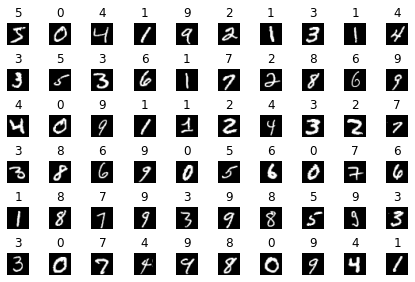

In [4]:
figure = plt.figure()
num_of_images = 60
for index in range(num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    plt.imshow(dataset_train.data[index,:,:], cmap='gray')
    plt.title(int(dataset_train.targets[index]))
plt.tight_layout()

In [5]:
dataset_01 = dataset_train.data.double()/255
print(dataset_01.max())
print(torch.mean(dataset_01))
print(torch.std(dataset_01))

tensor(1., dtype=torch.float64)
tensor(0.1307, dtype=torch.float64)
tensor(0.3081, dtype=torch.float64)


In [6]:
# function that acts on the data as a pre-processing stage
mnist_transform = torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(), # transforms the dataset to tensor from PIL/numpy + scale: [0,255] -> [0,1]
                              torchvision.transforms.Normalize(0.1307, 0.3081) # mean & std of train set
                             ]) 

# download the train and test dataset
# Note: this transformation `mnist_transform` will be activated only upon dataloader call
dataset_train = torchvision.datasets.MNIST(dataset_save_path, train=True, download=True,
                             transform=mnist_transform)
dataset_test = torchvision.datasets.MNIST(dataset_save_path, train=False, download=True,
                             transform=mnist_transform)

In [7]:
batch_size_train = 64
batch_size_test = 1000 # the test batch size is larger because this is less compute intensive


train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)
# shuffle: set to True to have the data reshuffled at every epoch

In [8]:
input_size = 28*28
hidden_sizes = [128, 64]
output_size = 10 # Num classes

model = nn.Sequential(nn.Flatten(),
                      nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): Softmax(dim=1)
)


In [9]:
print(f" is cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 is cuda available: False


In [10]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [11]:
def test(model,test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Move batch to device
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            correct += int((predicted == labels).sum())
    print(f"Accuracy of the network on {dataset_test.data.shape[0]} test images: {100 * correct / total}%")

test(model,test_loader)

Accuracy of the network on 10000 test images: 6.43%


In [12]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 3
for e in range(epochs):
    model.train()
    epoch_sum_loss = 0
    
    # Run mini-batch
    for images, labels in train_loader:
        # Move batch to davice
        images = images.to(device)
        labels = labels.to(device)
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        epoch_sum_loss += loss
    print(f"Epoch {e} - Training epoch mean loss: {epoch_sum_loss/len(train_loader)}")

Epoch 0 - Training epoch mean loss: 1.575196385383606
Epoch 1 - Training epoch mean loss: 1.514231562614441
Epoch 2 - Training epoch mean loss: 1.5035151243209839


In [13]:
test(model, test_loader)

Accuracy of the network on 10000 test images: 95.59%


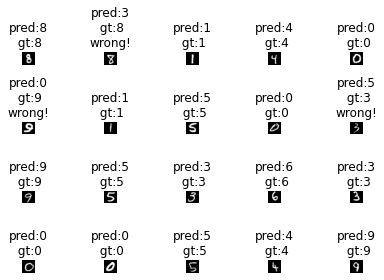

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images.to(device))

predicted = torch.argmax(outputs, dim=1)

figure = plt.figure()
num_of_images = 20
for index in range(num_of_images):
    plt.subplot(4, 5, index+1)
    plt.axis('off')
    plt.imshow(images[index,0,:,:], cmap='gray')
    prd = int(predicted[index])
    gt = int(labels[index])
    plt.title(f"pred:{prd}\n gt:{gt}" +"\nwrong!"*(prd!=gt))
plt.tight_layout()